In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.metrics import confusion_matrix
import seaborn as sns
import imageio
import imgaug as ia
import imgaug.augmenters as iaa

import torch
from torch import nn
from torch.nn import functional as F

In [2]:
def plot(a,b):
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.subplot(1,2,2)
    plt.imshow(b)
    plt.show()

### Load labeled nucleus 

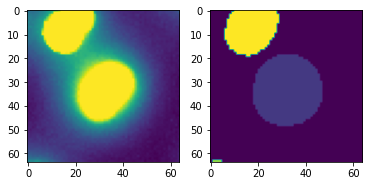

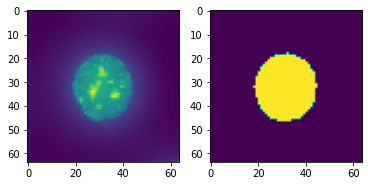

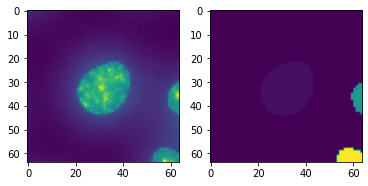

In [3]:
# Data extracted from Stardist without attention preprocessing

# load nucleus
fst = np.load('nuc_labeling/nucleus.npy')

# load labels
scd = np.load('nuc_labeling/labels.npy').astype('float')

# load targets
tags = np.load('nuc_labeling/tags.npy')

# DAPI 152 (:721)
i = 0
plot(fst[i],scd[i])

# DAPI 63 (721:1425)
i = 721
plot(fst[i],scd[i])

# DAPI 110 (1425:)
i = 1425 
plot(fst[i],scd[i])

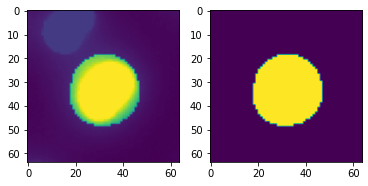

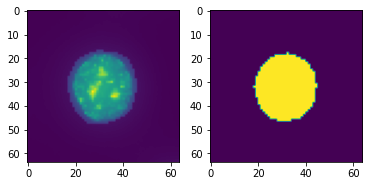

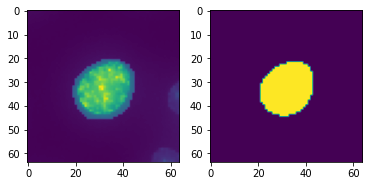

In [4]:
# Data extracted from Stardist with attention preprocessing

fst = np.load('nuc_labeling/nucleus1.npy')
scd = np.load('nuc_labeling/labels1.npy').astype('float')
tags = np.load('nuc_labeling/tags1.npy')

# DAPI 152 (:721)
i = 0
plot(fst[i],scd[i])

# DAPI 63 (721:1425)
i = 721
plot(fst[i],scd[i])

# DAPI 110 (1425:)
i = 1425 
plot(fst[i],scd[i])

In [5]:
# split data
fst_152 = fst[:721]
scd_152 = scd[:721]
tags_152 = tags[:721]

fst_63 = fst[721:1425]
scd_63 = scd[721:1425]
tags_63 = tags[721:1425]

fst_110 = fst[1425:]
scd_110 = scd[1425:]
tags_110 = tags[1425:]

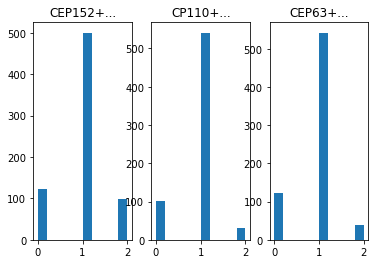

In [6]:
# distribution
plt.subplot(1,3,1)
plt.hist(tags_152)
plt.title('CEP152+...')

plt.subplot(1,3,2)
plt.hist(tags_110)
plt.title('CP110+...')

plt.subplot(1,3,3)
plt.hist(tags_63)
plt.title('CEP63+...')

plt.show()

0: `border`  
1: `good`  
2: `uncertain`  

In [7]:
# Count value in each class for each chanel
nucleus = [tags_152, tags_110, tags_63]
values = [[np.count_nonzero(dapi == elem) for elem in np.unique(dapi)] for dapi in nucleus]
values

[[123, 500, 98], [101, 541, 31], [122, 542, 40]]

In [8]:
# How many times does it need to be augmented for balanced classes ? 
aug_nb = np.ceil([list(map(lambda x: max(triplet)/x, triplet)) for triplet in values]).astype('int32') - 1
aug_nb

array([[ 4,  0,  5],
       [ 5,  0, 17],
       [ 4,  0, 13]])

> We need to augment between 4 and 17 times different classes. The class `good` is the numerous one in all cases

### Data Aug

We augment the data by stretching, flipping and rotating it.

In [9]:
# Define functions
rotate = iaa.Affine(rotate=(-90, 10))
cropx = iaa.Crop(percent=(0, .1))
cropy = iaa.Crop(percent=(.1, 0))


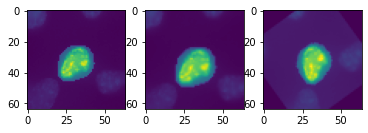

In [10]:
# Example
image = fst_110[153]
corpx_image=cropx.augment_image(image)
corpy_image=cropy.augment_image(image)
rotated_image=rotate.augment_image(image)

plt.subplot(1,3,1)
plt.imshow(image)
plt.subplot(1,3,2)
plt.imshow(corpy_image)
plt.subplot(1,3,3)
plt.imshow(rotated_image)
plt.show()

In [11]:
# Recall
# How many times does it need to be augmented for balanced classes ? 
aug_nb = np.ceil([list(map(lambda x: max(triplet)/x, triplet)) for triplet in values]).astype('int32') - 1
aug_nb

array([[ 4,  0,  5],
       [ 5,  0, 17],
       [ 4,  0, 13]])

In [12]:
# augment 152
fst152 = fst_152.copy()
scd152 = scd_152.copy()
tags152 = tags_152.copy()

tags_img = tags_152
#********************* 152 label 0 => 4x ***********************
img = fst_152
label = 0

flip1 = np.array([np.flipud(item) for item in img[tags_img==label]])
flip2 = np.array([np.fliplr(item) for item in img[tags_img==label]])
rot1 = np.array([np.rot90(item,1) for item in img[tags_img==label]])
rot2 = np.array([np.rot90(item,2) for item in img[tags_img==label]])

aug_img = np.concatenate((flip1,flip2,rot1,rot2), axis = 0)
fst152 = np.concatenate((fst152, aug_img))

#***********************************************************
img = scd_152
label = 0

flip1 = np.array([np.flipud(item) for item in img[tags_img==label]])
flip2 = np.array([np.fliplr(item) for item in img[tags_img==label]])
rot1 = np.array([np.rot90(item,1) for item in img[tags_img==label]])
rot2 = np.array([np.rot90(item,2) for item in img[tags_img==label]])

aug_img = np.concatenate((flip1,flip2,rot1,rot2), axis = 0)
scd152 = np.concatenate((scd152,aug_img))

aug_tags = label * np.ones(len(aug_img))
tags152 = np.concatenate((tags152,aug_tags))

#************************ 152 label 2 => 5x ********************
img = fst_152
label = 2

flip1 = np.array([np.flipud(item) for item in img[tags_img==label]])
flip2 = np.array([np.fliplr(item) for item in img[tags_img==label]])
rot1 = np.array([np.rot90(item,1) for item in img[tags_img==label]])
rot2 = np.array([np.rot90(item,2) for item in img[tags_img==label]])
rot3 = np.array([np.rot90(item,3) for item in img[tags_img==label]])

aug_img = np.concatenate((flip1,flip2,rot1,rot2,rot3), axis = 0)
fst152 = np.concatenate((fst152, aug_img))

#**********************************************************
img = scd_152
label = 2

flip1 = np.array([np.flipud(item) for item in img[tags_img==label]])
flip2 = np.array([np.fliplr(item) for item in img[tags_img==label]])
rot1 = np.array([np.rot90(item,1) for item in img[tags_img==label]])
rot2 = np.array([np.rot90(item,2) for item in img[tags_img==label]])
rot3 = np.array([np.rot90(item,3) for item in img[tags_img==label]])

aug_img = np.concatenate((flip1,flip2,rot1,rot2,rot3), axis = 0)
scd152 = np.concatenate((scd152, aug_img))

aug_tags = label * np.ones(len(aug_img))
tags152 = np.concatenate((tags152,aug_tags))

#**********************************************************
#**********************************************************

# augment 110

fst110 = fst_110.copy()
scd110 = scd_110.copy()
tags110 = tags_110.copy()

tags_img = tags_110 
#********************* 110 label 0 => 5x ***********************
img = fst_110
label = 0

flip1 = np.array([np.flipud(item) for item in img[tags_img==label]])
flip2 = np.array([np.fliplr(item) for item in img[tags_img==label]])
rot1 = np.array([np.rot90(item,1) for item in img[tags_img==label]])
rot2 = np.array([np.rot90(item,2) for item in img[tags_img==label]])
rot3 = np.array([np.rot90(item,3) for item in img[tags_img==label]])

aug_img = np.concatenate((flip1,flip2,rot1,rot2,rot3), axis = 0)
fst110 = np.concatenate((fst110, aug_img))

#***********************************************************
img = scd_110
label = 0

flip1 = np.array([np.flipud(item) for item in img[tags_img==label]])
flip2 = np.array([np.fliplr(item) for item in img[tags_img==label]])
rot1 = np.array([np.rot90(item,1) for item in img[tags_img==label]])
rot2 = np.array([np.rot90(item,2) for item in img[tags_img==label]])
rot3 = np.array([np.rot90(item,3) for item in img[tags_img==label]])

aug_img = np.concatenate((flip1,flip2,rot1,rot2,rot3), axis = 0)
scd110 = np.concatenate((scd110,aug_img))

aug_tags = label * np.ones(len(aug_img))
tags110 = np.concatenate((tags110,aug_tags))

#************************ 110 label 2 => 17x ******************************
img = fst_110
label = 2

flip1 = np.array([np.flipud(item) for item in img[tags_img==label]])
flip2 = np.array([np.fliplr(item) for item in img[tags_img==label]])
rot1 = np.array([np.rot90(item,1) for item in img[tags_img==label]])
rot2 = np.array([np.rot90(item,2) for item in img[tags_img==label]])
rot3 = np.array([np.rot90(item,3) for item in img[tags_img==label]])

dummy = np.array([rotate.augment_image(item) for item in img])

flip3 = np.array([np.flipud(item) for item in dummy[tags_img==label]])
flip4 = np.array([np.fliplr(item) for item in dummy[tags_img==label]])
rot4 = np.array([np.rot90(item,1) for item in dummy[tags_img==label]])
rot5 = np.array([np.rot90(item,2) for item in dummy[tags_img==label]])
rot6 = np.array([np.rot90(item,3) for item in dummy[tags_img==label]])

dummy = np.array([cropx.augment_image(item) for item in img])

flip5 = np.array([np.flipud(item) for item in dummy[tags_img==label]])
flip6 = np.array([np.fliplr(item) for item in dummy[tags_img==label]])
rot7 = np.array([np.rot90(item,1) for item in dummy[tags_img==label]])
rot8 = np.array([np.rot90(item,2) for item in dummy[tags_img==label]])
rot9 = np.array([np.rot90(item,3) for item in dummy[tags_img==label]])

aug_img = np.concatenate((flip1,flip2,rot1,rot2,rot3,
                          flip3,flip4,rot4,rot5,rot6,
                          flip5,flip6,rot7,rot8,rot9,
                          dummy[tags_img==label]), axis = 0)
fst110 = np.concatenate((fst110, aug_img))

#**********************************************************
img = scd_110
label = 2

flip1 = np.array([np.flipud(item) for item in img[tags_img==label]])
flip2 = np.array([np.fliplr(item) for item in img[tags_img==label]])
rot1 = np.array([np.rot90(item,1) for item in img[tags_img==label]])
rot2 = np.array([np.rot90(item,2) for item in img[tags_img==label]])
rot3 = np.array([np.rot90(item,3) for item in img[tags_img==label]])

dummy = np.array([rotate.augment_image(item) for item in img])

flip3 = np.array([np.flipud(item) for item in dummy[tags_img==label]])
flip4 = np.array([np.fliplr(item) for item in dummy[tags_img==label]])
rot4 = np.array([np.rot90(item,1) for item in dummy[tags_img==label]])
rot5 = np.array([np.rot90(item,2) for item in dummy[tags_img==label]])
rot6 = np.array([np.rot90(item,3) for item in dummy[tags_img==label]])

dummy = np.array([cropx.augment_image(item) for item in img])

flip5 = np.array([np.flipud(item) for item in dummy[tags_img==label]])
flip6 = np.array([np.fliplr(item) for item in dummy[tags_img==label]])
rot7 = np.array([np.rot90(item,1) for item in dummy[tags_img==label]])
rot8 = np.array([np.rot90(item,2) for item in dummy[tags_img==label]])
rot9 = np.array([np.rot90(item,3) for item in dummy[tags_img==label]])


aug_img = np.concatenate((flip1,flip2,rot1,rot2,rot3,
                          flip3,flip4,rot4,rot5,rot6,
                          flip5,flip6,rot7,rot8,rot9,
                          dummy[tags_img==label]), axis = 0)
scd110 = np.concatenate((scd110, aug_img))

aug_tags = label * np.ones(len(aug_img))
tags110 = np.concatenate((tags110,aug_tags))

#**********************************************************
#**********************************************************
# augment 63

fst63 = fst_63.copy()
scd63 = scd_63.copy()
tags63 = tags_63.copy()

tags_img = tags_63
#************************* 63 label 0  => 4x *****************
img = fst_63
label = 0

flip1 = np.array([np.flipud(item) for item in img[tags_img==label]])
flip2 = np.array([np.fliplr(item) for item in img[tags_img==label]])
rot1 = np.array([np.rot90(item,1) for item in img[tags_img==label]])
rot2 = np.array([np.rot90(item,2) for item in img[tags_img==label]])

aug_img = np.concatenate((flip1,flip2,rot1,rot2), axis = 0)
fst63 = np.concatenate((fst63, aug_img))

#***********************************************************
img = scd_63
label = 0

flip1 = np.array([np.flipud(item) for item in img[tags_img==label]])
flip2 = np.array([np.fliplr(item) for item in img[tags_img==label]])
rot1 = np.array([np.rot90(item,1) for item in img[tags_img==label]])
rot2 = np.array([np.rot90(item,2) for item in img[tags_img==label]])

aug_img = np.concatenate((flip1,flip2,rot1,rot2), axis = 0)
scd63 = np.concatenate((scd63,aug_img))

aug_tags = label * np.ones(len(aug_img))
tags63 = np.concatenate((tags63,aug_tags))

#********************  63 label 2  => 13x *****************************
img = fst_63
label = 2

flip1 = np.array([np.flipud(item) for item in img[tags_img==label]])
flip2 = np.array([np.fliplr(item) for item in img[tags_img==label]])
rot1 = np.array([np.rot90(item,1) for item in img[tags_img==label]])
rot2 = np.array([np.rot90(item,2) for item in img[tags_img==label]])
rot3 = np.array([np.rot90(item,3) for item in img[tags_img==label]])

dummy = np.array([rotate.augment_image(item) for item in img])

flip3 = np.array([np.flipud(item) for item in dummy[tags_img==label]])
flip4 = np.array([np.fliplr(item) for item in dummy[tags_img==label]])
rot4 = np.array([np.rot90(item,1) for item in dummy[tags_img==label]])
rot5 = np.array([np.rot90(item,2) for item in dummy[tags_img==label]])
rot6 = np.array([np.rot90(item,3) for item in dummy[tags_img==label]])

dummy = np.array([cropx.augment_image(item) for item in img])

flip5 = np.array([np.flipud(item) for item in dummy[tags_img==label]])
flip6 = np.array([np.fliplr(item) for item in dummy[tags_img==label]])
rot7 = np.array([np.rot90(item,1) for item in dummy[tags_img==label]])

aug_img = np.concatenate((flip1,flip2,rot1,rot2,rot3,
                          flip3,flip4,rot4,rot5,rot6,
                          flip5,flip6,rot7), axis = 0)
fst63 = np.concatenate((fst63, aug_img))

#**********************************************************
img = scd_63
label = 2

flip1 = np.array([np.flipud(item) for item in img[tags_img==label]])
flip2 = np.array([np.fliplr(item) for item in img[tags_img==label]])
rot1 = np.array([np.rot90(item,1) for item in img[tags_img==label]])
rot2 = np.array([np.rot90(item,2) for item in img[tags_img==label]])
rot3 = np.array([np.rot90(item,3) for item in img[tags_img==label]])

dummy = np.array([rotate.augment_image(item) for item in img])

flip3 = np.array([np.flipud(item) for item in dummy[tags_img==label]])
flip4 = np.array([np.fliplr(item) for item in dummy[tags_img==label]])
rot4 = np.array([np.rot90(item,1) for item in dummy[tags_img==label]])
rot5 = np.array([np.rot90(item,2) for item in dummy[tags_img==label]])
rot6 = np.array([np.rot90(item,3) for item in dummy[tags_img==label]])

dummy = np.array([cropx.augment_image(item) for item in img])

flip5 = np.array([np.flipud(item) for item in dummy[tags_img==label]])
flip6 = np.array([np.fliplr(item) for item in dummy[tags_img==label]])
rot7 = np.array([np.rot90(item,1) for item in dummy[tags_img==label]])

aug_img = np.concatenate((flip1,flip2,rot1,rot2,rot3,
                          flip3,flip4,rot4,rot5,rot6,
                          flip5,flip6,rot7), axis = 0)
scd63 = np.concatenate((scd63, aug_img))

aug_tags = label * np.ones(len(aug_img))
tags63 = np.concatenate((tags63,aug_tags))


In [13]:
# Count with augmentation
nucleus = [tags152, tags110, tags63]
values = [[np.count_nonzero(dapi == elem) for elem in np.unique(dapi)] for dapi in nucleus]
values

[[615, 500, 588], [606, 541, 527], [610, 542, 560]]

In [14]:
# Take first 500 of each
fst152 = np.concatenate(([fst152[tags152 == i][:500] for i in (0,1,2)]), axis=0)
scd152 = np.concatenate(([scd152[tags152 == i][:500] for i in (0,1,2)]), axis=0)
tags152 = np.concatenate(([tags152[tags152 == i][:500] for i in (0,1,2)]), axis=0)

fst110 = np.concatenate(([fst110[tags110 == i][:500] for i in (0,1,2)]), axis=0)
scd110 = np.concatenate(([scd110[tags110 == i][:500] for i in (0,1,2)]), axis=0)
tags110 = np.concatenate(([tags110[tags110 == i][:500] for i in (0,1,2)]), axis=0)

fst63 = np.concatenate(([fst63[tags63 == i][:500] for i in (0,1,2)]), axis=0)
scd63 = np.concatenate(([scd63[tags63 == i][:500] for i in (0,1,2)]), axis=0)
tags63 = np.concatenate(([tags63[tags63 == i][:500] for i in (0,1,2)]), axis=0)

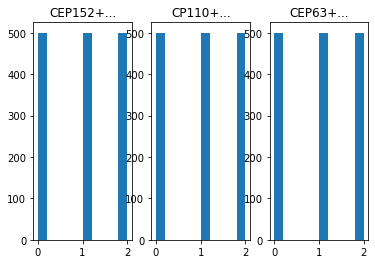

In [15]:
# distribution
plt.subplot(1,3,1)
plt.hist(tags152)
plt.title('CEP152+...')

plt.subplot(1,3,2)
plt.hist(tags110)
plt.title('CP110+...')

plt.subplot(1,3,3)
plt.hist(tags63)
plt.title('CEP63+...')

plt.show()

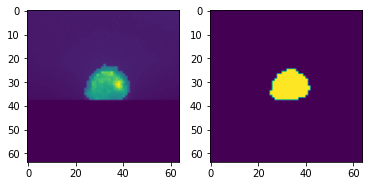

0.0


In [16]:
# sanity check
i = np.random.randint(450*3)
plot(fst110[i], scd110[i]) 
print(tags110[i])

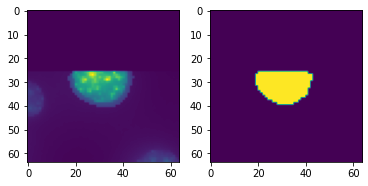

0.0


In [17]:
# sanity check
i = np.random.randint(450*3)
plot(fst63[i], scd63[i])
print(tags63[i])

### To torch

In [18]:
# stdz data
fst152 = (fst152-fst152.mean())/fst152.std()
scd152 = (scd152-scd152.mean())/scd152.std()

fst110 = (fst110-fst110.mean())/fst110.std()
scd110 = (scd110-scd110.mean())/scd110.std()

fst63 = (fst63-fst63.mean())/fst63.std()
scd63 = (scd63-scd63.mean())/scd63.std()

In [19]:
# 152+110 => train

# merge each file
fst_tr = np.concatenate((fst152,fst110), axis = 0) 
scd_tr = np.concatenate((scd152,scd110), axis = 0)
tags_tr = np.concatenate((tags152,tags110), axis = 0)

# Creates a tensor of shape x_tr: Nx2x64x64 and y_tr: N
all_ = [np.array([a,b]) for a,b in zip (fst_tr,scd_tr)]
x_tr = torch.from_numpy(np.array(all_)).float()
y_tr = torch.from_numpy(tags_tr).long()

x_tr.shape, y_tr.shape

(torch.Size([3000, 2, 64, 64]), torch.Size([3000]))

In [20]:
# 63 => test
all_ = [np.array([a,b]) for a,b in zip (fst63,scd63)]
x_te = torch.from_numpy(np.array(all_)).float()
y_te = torch.from_numpy(tags63).long()

x_te.shape, y_te.shape

(torch.Size([1500, 2, 64, 64]), torch.Size([1500]))

In [21]:
# Function to shuffle data at each epoch
def shuffle_data(data ,target, nb):
        _,index = torch.empty(nb).normal_().sort()
        data = data[index]
        target = target[index]
        return data, target
    
x_tr, y_tr = shuffle_data(x_tr, y_tr, len(y_tr))

In [231]:
# Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.fc1 = nn.Linear(512, 250)
        self.fc2 = nn.Linear(250, 100)
        self.fc3 = nn.Linear(100, 3)
        
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.batch_norm4 = nn.BatchNorm1d(250)
        self.batch_norm5 = nn.BatchNorm1d(100)
        
        self.activation = nn.Softmax(1)

    def forward(self, x):
        # 2x64x64 >> 32x60x60 >> 32x20x20
        x = F.relu(self.batch_norm1(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3)))
        # 32x20x20 >> 64x18x18 >> 64x6x6
        x = F.relu(self.batch_norm2(F.max_pool2d(self.conv2(x), kernel_size=3, stride=3)))
        # 64x6x6 >> 128x4x4 >> 128x2x2
        x = F.relu(self.batch_norm3(F.max_pool2d(self.conv3(x), kernel_size=2, stride=2)))
        # 128x2x2 >> 512 >> 250
        x = F.relu(self.batch_norm4(self.fc1(x.view(-1, 512))))
        # 250 >> 100
        x = F.relu(self.batch_norm5(self.fc2(x)))
        # 100 >> 3
        x = self.activation(self.fc3(x))
        
        return x
    
model = Net()

In [232]:
def train_model(model, train_input, train_target, mini_batch_size, nb_epochs = 30, lr=0.05):
    
    # Method to improve the model
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)
    loss_evol = []

    # epoch = nbr of time we go through all the data
    for e in range(nb_epochs):  
        acc_loss = 0
        
        shuff_input, shuff_target = shuffle_data(train_input, train_target, len(train_target))
        for b in range(0, train_input.size(0), mini_batch_size):
            
            #get output of the model with input = b-th mini_batch
            output = model(shuff_input.narrow(0, b, mini_batch_size))
            
            #compute loss, following defined criteria
            loss = criterion(output, shuff_target.narrow(0, b, mini_batch_size)) 
            acc_loss = acc_loss + loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        loss_evol.append(acc_loss)
        print(e, acc_loss)
        

In [233]:
model = Net()
train_model(model, x_tr, y_tr, mini_batch_size=100, nb_epochs = 100, lr=0.03)

0 27.41435945034027
1 23.55299425125122
2 22.04672372341156
3 21.072376608848572
4 20.42355042695999
5 19.942021071910858
6 19.46041363477707
7 19.07539129257202
8 18.823905527591705
9 18.519457638263702
10 18.27916669845581
11 18.046213805675507
12 17.86728072166443
13 17.674721717834473
14 17.560111582279205
15 17.39621889591217
16 17.377214550971985
17 17.24343913793564
18 17.183253288269043
19 17.136603355407715
20 17.019862413406372
21 16.98513436317444
22 16.943198800086975
23 16.914917767047882
24 16.8673814535141
25 16.833671152591705
26 16.823315858840942
27 16.815078735351562
28 16.807214856147766
29 16.793245494365692
30 16.77043914794922
31 16.797753751277924
32 16.73930996656418
33 16.73142820596695
34 16.73422610759735
35 16.714612424373627
36 16.705358266830444
37 16.706463992595673
38 16.707696199417114
39 16.697002291679382
40 16.70211434364319
41 16.69207352399826
42 16.693303763866425
43 16.701840102672577
44 16.68073457479477
45 16.674038469791412
46 16.663593113422

In [257]:
# Compute results on test set
output = model(x_te)
value,idx = output.max(1)

C:\Users\David\anaconda3\envs\ml2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


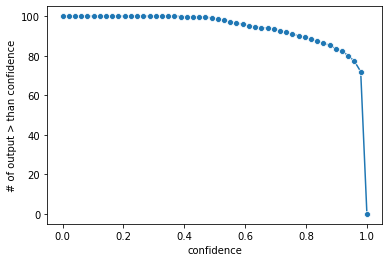

In [270]:
# Output confidence ratio
xs = np.linspace(0,1,50)
y = np.array(([((value>x).sum()/len(value)).item()*100 for x in xs]))
sns.lineplot(xs,y, marker = 'o')
plt.ylabel('# of output > than confidence')
plt.xlabel('confidence')
plt.show()

In [271]:
# Threshold we could trust
p = 0.85
(value>p).sum()/len(value)

tensor(0.8667)

In [273]:
# About 90% of output with p > 0.85 are correct
(idx[value>p]==y_te[value>p]).sum()/len(y_te[value>p])*100

tensor(87.8462)

Confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.

In [276]:
# Get confusion matrix
conf_m = confusion_matrix(idx[value>p], y_te[value>p],normalize='true')
conf_m

array([[0.93548387, 0.03655914, 0.02795699],
       [0.0422833 , 0.79281184, 0.16490486],
       [0.02762431, 0.05524862, 0.91712707]])

> There is 5% of false positive

<AxesSubplot:>

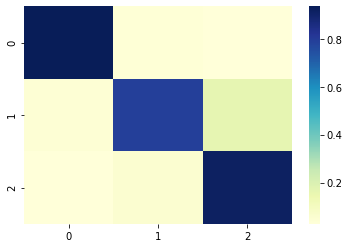

In [277]:
sns.heatmap(conf_m, cmap="YlGnBu")

In [278]:
# Export model
torch.save(model.state_dict(), 'modelLast')